In [1]:
# Some questions that will hopefully be answered by the end of this notebook

# * How much energy per year can a single satellite sell to the grid? Assume optimal orbit and full client capacity
# * What percentage of the time does a satellite have a target farm in sight?
# * What are the best and average LCOE?
# * What is the annual ROI for a single satellite?

In [2]:
%%capture
# Imports

try:
  import cartopy.crs as ccrs
except:
  !conda install cartopy
  import cartopy.crs as ccrs
    
try:
  from shapely.geometry import Polygon
  from shapely.ops import unary_union
except:
  !conda install shapely
  from shapely.geometry import Polygon
  from shapely.ops import unary_union

try:
  from descartes import PolygonPatch
except:
  !conda install descartes -y
  from descartes import PolygonPatch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from matplotlib import collections
from matplotlib import patches
from scipy.signal import argrelextrema

%matplotlib inline

In [3]:
# Units
# -----
# Power -> kW
# Energy -> kWh
# Money -> USD
# Mass -> kg
# Time -> s
# Distance -> m

In [4]:
# General settings

# Sim
POINTS_PER_ORBIT = 86400 // 90 # ~ 1 point every 90s in a daily orbit
POINTS_PER_YEAR = 365 // 15 # 1 point every 15 days in a yearly orbit around the Sun
ORBIT_PHASES = 4 # orbit phases can be considered phase shifts in the ground tracks: which longitude does the RAAN cross at time=0?

FARM_COSINE_LOSSES = True # consider losses due to the satellite not being perfectly on top of the farm
FARM_AREA_LOSSES = True # consider losses due to the beam area being larger than the farm area

# Data
MIN_ALLOWABLE_TRANSMISSION = 0.6 # as a % of max transmission
EXCLUDE_COUNTRIES = ["CHN", "China"] # no farms from the countries in this list 
INCLUDE_FARM_STATUS = "operating", "construction",# "pre-construction", "announced" # choose all that apply
MIN_FARM_POWER_CAPTURE = 0.2 # no farms incapable of harnessing at least this much fraction of beamed power
DROPOUT = 1-4/5 # each farm is a client with P=1-DROPOUT

np.random.seed(1337)

In [5]:
# General constants

# Earth
EARTH_ROTATION_PERIOD = 86400
EARTH_MEAN_RADIUS = 6367444.65
EARTH_TILT = 23.4

# Sun
SUN_SUBTENDED_ANGLE = 0.5

# Satellite
ORBIT_ALTITUDE = 600000 # (https://en.wikipedia.org/wiki/Sun-synchronous_orbit)
ORBIT_PERIOD = EARTH_ROTATION_PERIOD / 15 # (https://en.wikipedia.org/wiki/Sun-synchronous_orbit)
ORBIT_INCLINATION = 97.7 # (https://en.wikipedia.org/wiki/Sun-synchronous_orbit)

# Solar power
SPACE_SOLAR_kWpm2 = 1.361 # (kW/m^2) https://en.wikipedia.org/wiki/Solar_irradiance
MYLAR_REFLECTIVITY = 0.9 # https://www.hydroponics.eu/mylar-silver-reflective-sheeting-15-x-1-2mt~31966.html

# Solar farms
PV_CELL_EFFICIENCY = 0.2 # https://en.wikipedia.org/wiki/Solar-cell_efficiency
SOLAR_INVERTER_LOSSES = 0.085 # ChatGPT and https://www.pv-magazine.com/2023/03/02/guide-to-understanding-solar-production-losses/

# Space industry
#KG_COST_TO_ORBIT = 2800 # Falcon 9
KG_COST_TO_ORBIT = 1500 # Falcon Heavy
#KG_COST_TO_ORBIT = 200 # Starship

# Reflect
ENERGY_PRICE = 83e-3
SUNNY_SKY_FREQ = 0.766

SAT_COST = 40e3
SAT_WEIGHT = 160
SAT_LIFE = 20
SAT_SURFACE = 54**2

In [6]:
# Variable definition (easy to use renames and derivations of settings)

R = EARTH_MEAN_RADIUS
h = ORBIT_ALTITUDE 
a = R + h
w_s = 2 * np.pi / ORBIT_PERIOD # Satellite angular velocity
i = ORBIT_INCLINATION * np.pi  / 180 # in radians
earth_tilt = EARTH_TILT * np.pi / 180 # in radians
orbit_points = POINTS_PER_ORBIT
T_earth = EARTH_ROTATION_PERIOD
sun_subtended = SUN_SUBTENDED_ANGLE * np.pi / 180 # in radians

In [7]:
# Helper functions

def cart_to_sph(p):
  """Cartesian to spherical coordinates"""
  ret = np.zeros(p.shape)
  xy = p[0]**2 + p[1]**2
  ret[0] = np.sqrt(xy + p[2]**2)
  ret[1] = np.arctan2(np.sqrt(xy), p[2])
  ret[2] = np.arctan2(p[1], p[0])
  return ret


def sph_to_cart(p):
  """Spherical to cartesian coordinates"""
  ret = np.zeros(p.shape)
  r, theta, phi = p[0], p[1], p[2]
  ret[0] = r * np.sin(theta) * np.cos(phi)
  ret[1] = r * np.sin(theta) * np.sin(phi)
  ret[2] = r * np.cos(theta)
  return ret


def ECI_to_ECEF(p, t):
  """Earth centered inertial to Earth centered, Earth fixed coordinates"""
  angle = 2*np.pi / EARTH_ROTATION_PERIOD * t # (orbit_points,)
  rot = np.array([
    [ np.cos(angle)        , np.sin(angle)        , np.zeros(angle.shape)],
    [-np.sin(angle)        , np.cos(angle)        , np.zeros(angle.shape)],
    [ np.zeros(angle.shape), np.zeros(angle.shape), np.ones(angle.shape) ]
  ]) # (3, 3, orbit_points)
  return np.einsum('ijk, jk->ik', rot, p) # (3, 3, orbit_points).(3, orbit_points) -> (3, orbit_points)


def ECEF_to_LatLon(p):
  """Earth centered, Earth fixed coordinates to Latitude and Longitude"""
  ret = cart_to_sph(p)
  lat = np.pi/2 - ret[1]
  lon = ret[2] % (2*np.pi) - np.pi
  return np.array([lat, lon])


def LatLon_to_ECEF(p, r=R):
  """Earth centered, Earth fixed coordinates to Latitude and Longitude"""
  radius = r * np.ones(p[0].shape)
  theta = np.pi/2 - p[0]
  phi = p[1] + np.pi
  ret = np.vstack([radius, theta, phi])
  ret = sph_to_cart(ret)
  return ret
  

def ECI_to_LatLon(p, t):
  """Earth centered inertial coordinates to Latitude and Longitude"""
  ret = ECI_to_ECEF(p, t)
  return ECEF_to_LatLon(ret)


def LatLon_to_Mercator(p):
  """Latitude and Longitude to Mercator coordinates"""
  ret = np.zeros(p.shape)
  lat, lon = p
  ret[0] = lon*EARTH_MEAN_RADIUS
  ret[1] = np.log(np.tan(0.25*np.pi + 0.5*lat))*EARTH_MEAN_RADIUS
  return ret


def Mercator_to_LatLon(p):
  """Mercator coordinates to Latitude and Longitude"""
  ret = np.zeros(p.shape)
  x, y = p
  ret[0] = 2*np.arctan(np.exp(y / EARTH_MEAN_RADIUS)) - np.pi * 0.5
  ret[1] = x / EARTH_MEAN_RADIUS
  return ret


def Tilted_to_ECI(p):
  """Tilted to Earth centered inertial coordinates"""
  rot = np.array([
    [ 1, 0                 ,  0                 ],
    [ 0, np.cos(earth_tilt), -np.sin(earth_tilt)],
    [ 0, np.sin(earth_tilt),  np.cos(earth_tilt)]
  ]) # (3, 3)
  return np.einsum('ij, jk->ik', rot, p) # (3, 3).(3, points) -> (3, points)


def ECI_to_Corotating(p, anomaly):
  """Earth centered inertial to Corotating coordinates"""
  rot = np.array([
    [ np.cos(anomaly)        , np.sin(anomaly)        , np.zeros(anomaly.shape)],
    [-np.sin(anomaly)        , np.cos(anomaly)        , np.zeros(anomaly.shape)],
    [ np.zeros(anomaly.shape), np.zeros(anomaly.shape), np.ones(anomaly.shape) ]
  ]) # (3, 3, anomaly_points)
  return np.einsum('ijk, jk->ik', rot, p) # (3, 3, anomaly_points).(3, points) -> (3, points)
 

def ECEF_to_Corotating(p, t):
  """Earth centered, Earth fixed to Corotating coordinates"""
  angle = 2*np.pi / EARTH_ROTATION_PERIOD * t # (orbit_points,)
  rot = np.array([
    [ np.cos(angle)        , -np.sin(angle)        , np.zeros(angle.shape)],
    [ np.sin(angle)        ,  np.cos(angle)        , np.zeros(angle.shape)],
    [ np.zeros(angle.shape),  np.zeros(angle.shape), np.ones(angle.shape) ]
  ]) # (3, 3, orbit_points)
  return np.einsum('ijk, jk...->ik...', rot, p) # (3, 3, orbit_points).(3, orbit_points) -> (3, orbit_points)


def dot(x, y):
  """Regular dot product"""
  return np.einsum('ik, ik -> k', x, y)


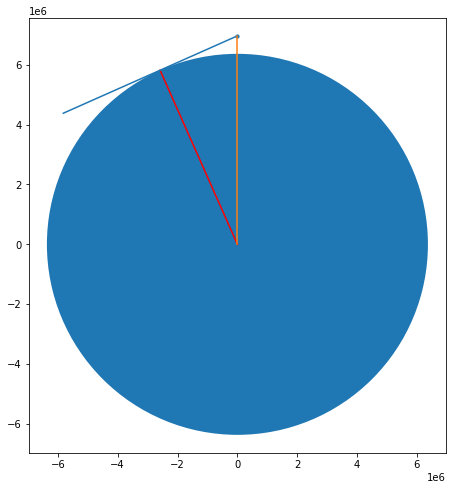

Half satellite FOV: 66.0º
Half Earth angular coverage: 24.0º


In [8]:
# Preliminary analisis 1

# How wide should the FOV of a satellite be to reach as many points on Earth as possible and what angular portion of the Earth does this represent? 

a_max = np.arcsin(R/(R+h)) # Max angular deviation from the normal as viewed from the satellite
b_max = np.arccos(R/(R+h)) # Max angular deviation from the normal as viewed from Earth's center

earth = patches.Circle((0, 0), R)

fig, ax = plt.subplots(figsize=(8, 8))
ax.add_patch(earth) # earth
ax.scatter(0, (R+h), s=10) # satellite

ax.plot([0, -R*np.sin(b_max)], [0, R*np.cos(b_max)], color='red')
ax.plot([0, -R*np.sin(a_max)], [R+h, R+h - R*np.cos(a_max)])
ax.plot([0, 0], [0, R+h])
ax.set_aspect('equal')
ax.set_xlim([-R-h, R+h])
ax.set_ylim([-R-h, R+2*h])

plt.show()

print(f"Half satellite FOV: {np.round(a_max * 180 / np.pi)}º")
print(f"Half Earth angular coverage: {np.round(b_max * 180 / np.pi)}º")

First order effective satellite FOV: 10.0º


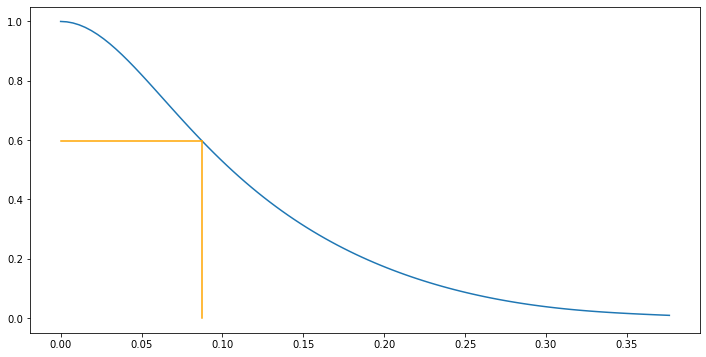

In [9]:
# Let's calculate how much of the power is lost merely by the angle at which the farm would receive the light
# to estimate satellite coverage to first order

b = np.linspace(start=0, stop=b_max*0.9, num=100) # Deviation from the normal viewed from Earth's center
r = np.array([-R*np.sin(b), R*np.cos(b)]) # Cartesian coordinates of the farm
sat = np.array([[0], [R+h]]) # Cartesian coordinates for the satellite

theta = np.pi/2 - np.arccos(dot(r,sat-r) / np.sqrt(dot(r, r)*dot(sat-r, sat-r))) # Angle from the farm's surface to the satellite
transmission = 0.1283 + 0.7548*np.exp(-0.3866/np.sin(theta)) # Transmission loss due to longer atmospheric path
transmission = transmission * np.sin(theta) # Transmission loss due to projection # this might be too restrictive
transmission = transmission / np.max(transmission)
idx = np.abs(transmission - MIN_ALLOWABLE_TRANSMISSION).argmin()
b_eff = b[idx]

plt.figure(figsize=(12, 6))
plt.plot(b, transmission)
plt.plot([b_eff, b_eff], [0, transmission[idx]], color='orange')
plt.plot([0, b_eff], [transmission[idx], transmission[idx]], color='orange')

print(f"First order effective satellite FOV: {np.round(2 * b_eff * 180 / np.pi)}º") # 2x to account for both sides

In [10]:
# Preliminary analisis 2

# How big is the smallest beam possible at the surface? How small of a farm does it make sense to consider?

# Let's calculate how much space farms take relative to their power

old_farms = []
with open("extra/old_farm_data.txt", "r") as f:
  for line in f.readlines():
    data = line.split("~")
    power, pv_coverage, ground_coverage = [float(p) for p in data[2:5]]
    if power > 300:
      old_farms.append([power, pv_coverage, ground_coverage])

old_farms = np.array(old_farms)
farm_km2_per_MW = np.average(old_farms[:, 2]/old_farms[:, 0])
ground_utilization_rate = np.average(old_farms[:, 1]/old_farms[:, 2])

farm_m2_per_kw = farm_km2_per_MW * 1000

min_beam_radius = h*np.tan(sun_subtended / 2)
min_beam_area = np.pi * min_beam_radius**2 # how much surface does the minimum beam cover?
min_beam_farm_equivalent = min_beam_area / farm_m2_per_kw

print(f"""The smallest beam (completely normal to the ground) is around {int(min_beam_area/1000000)}km^2 ({min_beam_radius}km radius). 
That's the area of a {int(min_beam_farm_equivalent/1000)}MW farm.""")
print(farm_m2_per_kw)

The smallest beam (completely normal to the ground) is around 21km^2 (2618.01049242094km radius). 
That's the area of a 523MW farm.
41.15300569065086


In [11]:
# Let's add the new constants

ORBIT_MAX_FOV = 2 * a_max * 180 / np.pi # in degrees
SATELLITE_MAX_GROUND_COVERAGE = 2 * b_max * 180 / np.pi # in degrees 
SATELLITE_EFFECTIVE_GROUND_COVERAGE = 2 * b_eff * 180 / np.pi # in degrees 

FARM_KM_PER_MW = farm_km2_per_MW
PANEL_SPACING_LOSSES = 1-ground_utilization_rate
MIN_FARM_POWER = min_beam_farm_equivalent * MIN_FARM_POWER_CAPTURE

In [12]:
MIN_FARM_POWER

104645.62439341068

In [13]:
# Let's see the ground tracks of a typical orbit with their potential farm coverage

# One day
t = np.linspace(start=1, stop=T_earth, num=orbit_points, endpoint=False) # (orbit_points,)

# Ground tracks
sat_eci = a*np.cos(w_s*t) # (orbit_points,) satellite cartesian x
sat_eci = np.vstack((sat_eci, a*np.sin(w_s*t)*np.cos(i))) # (2, orbit_points) satellite cartesian y
sat_eci = np.vstack((sat_eci, a*np.sin(w_s*t)*np.sin(i))) # (3, orbit_points) satellite cartesian z
sat_latlon = ECI_to_LatLon(sat_eci, t) # (2, orbit_points) satelite latlon
sat_mercator = LatLon_to_Mercator(sat_latlon) # (2, orbit_points) satellite mercator

# FOV bounds
# upper bound
ub_eci = a*np.cos(w_s*t)*np.cos(b_eff) # (orbit_points,)
ub_eci = np.vstack((ub_eci,  a*np.sin(w_s*t)*np.cos(i)*np.cos(b_eff) - a*np.sin(i)*np.sin(b_eff))) # (2, orbit_points)
ub_eci = np.vstack((ub_eci,  a*np.sin(w_s*t)*np.sin(i)*np.cos(b_eff) - a*np.cos(i)*np.sin(b_eff))) # (2, orbit_points)
ub_latlon = ECI_to_LatLon(ub_eci, t) # (2, orbit_points)
ub_mercator = LatLon_to_Mercator(ub_latlon) # (2, orbit_points)
# lower bound
lb_eci = a*np.cos(w_s*t)*np.cos(b_eff) # (orbit_points,)
lb_eci = np.vstack((lb_eci,  a*np.sin(w_s*t)*np.cos(i)*np.cos(b_eff) + a*np.sin(i)*np.sin(b_eff))) # (2, orbit_points)
lb_eci = np.vstack((lb_eci,  a*np.sin(w_s*t)*np.sin(i)*np.cos(b_eff) + a*np.cos(i)*np.sin(b_eff))) # (2, orbit_points)
lb_latlon = ECI_to_LatLon(lb_eci, t) # (2, orbit_points)
lb_mercator = LatLon_to_Mercator(lb_latlon) # (2, orbit_points)
# combined
bounds_mercator = np.stack((ub_mercator.T, lb_mercator.T), axis=1) # (orbit_points, ub/lb, x/y)
ub_problem_filter = np.abs(sat_mercator[0] - bounds_mercator[:, 0, 0]) > R * 1.5 * np.pi
lb_problem_filter = np.abs(sat_mercator[0] - bounds_mercator[:, 1, 0]) > R * 1.5 * np.pi
bounds_mercator[ub_problem_filter, 0, 0] = R * np.pi * np.sign(sat_mercator[0, ub_problem_filter] - bounds_mercator[ub_problem_filter, 0, 0]) 
bounds_mercator[lb_problem_filter, 1, 0] = R * np.pi * np.sign(sat_mercator[0, lb_problem_filter] - bounds_mercator[lb_problem_filter, 1, 0]) 

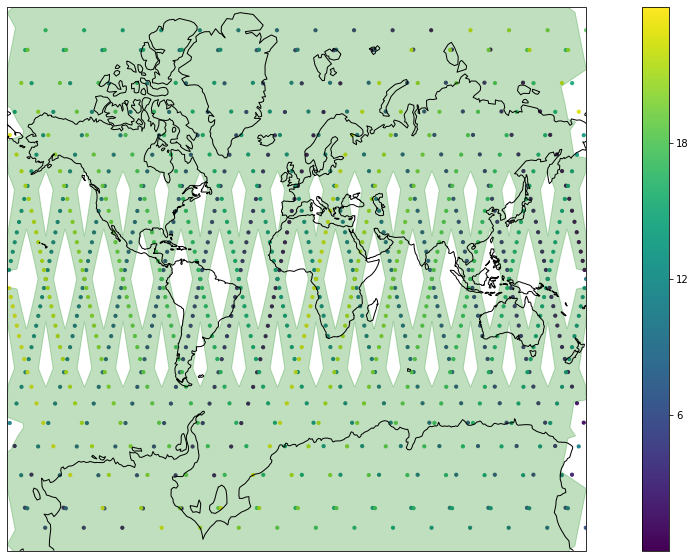

In [14]:
max_lat = 84

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.Mercator(min_latitude=-max_lat, max_latitude=max_lat)})

# Satellite FOV patches
splits = argrelextrema((sat_mercator[0]), np.greater)[0]
splits = np.insert(splits, [0, len(splits)], [0, orbit_points])

polys = []
for idx in np.arange(len(splits)-1):
  tmp_x1 = bounds_mercator[splits[idx]:splits[idx+1], 0, 0]
  tmp_x2 = bounds_mercator[splits[idx]:splits[idx+1], 1, 0]
  tmp_y1 = bounds_mercator[splits[idx]:splits[idx+1], 0, 1]
  tmp_y2 = bounds_mercator[splits[idx]:splits[idx+1], 1, 1]
  tmp_x = np.concatenate((tmp_x1[1:], np.flip(tmp_x2[1:])))
  tmp_y = np.concatenate((tmp_y1[1:], np.flip(tmp_y2[1:])))    
  vertices = np.vstack((tmp_x, tmp_y)).T
  polys.append(Polygon(vertices))

union_poly = unary_union(polys)
patch = PolygonPatch(union_poly, color='green', alpha=0.25)
ax.add_patch(patch)

# Satellite ground track
sat_ground_track = ax.scatter(sat_mercator[0], sat_mercator[1], c=t/60/60, s=10)
ax.coastlines()

x_lim = R*np.pi
y_lim = R*np.log(np.tan(np.deg2rad(max_lat/2)+np.pi/4))
ax.set_xlim([-x_lim, x_lim])
ax.set_ylim([-y_lim, y_lim])

ticks = np.linspace(start=0, stop=24, num=5)
plt.colorbar(sat_ground_track, ticks=ticks)
plt.show()

In [15]:
# Let's import the solar farm data

excel = pd.ExcelFile("extra/farm_data.xlsx")
df_large = pd.read_excel(excel, "Large Utility-Scale") # farms over 20MW (10MW for Arab countries)
df_medium = pd.read_excel(excel, "Medium Utility-Scale") # farms lower than 10MW (10MW for Arab countries)
df = pd.concat([df_large, df_medium], ignore_index=True, axis=0) # all farms
df = df.loc[
    (~df['Country'].isin(EXCLUDE_COUNTRIES))
  & (df['Capacity (MW)'] >= MIN_FARM_POWER/1e3)
  & (df['Status'].isin(INCLUDE_FARM_STATUS))
] # Filter to exclude forbidden countries, low power farms and focus on operational/in-construction ones

df = df.filter(items=['Latitude', 'Longitude', 'Capacity (MW)']) # filter relevant data
farm_data = df.to_numpy()
if DROPOUT:
  idx = np.random.binomial(n=1, p=1-DROPOUT, size=len(farm_data))
  farm_data = farm_data[idx == 1] # (farms, 3)
farm_number = len(farm_data)
farm_data = farm_data.T # (3, farms)
farm_data[:2] = np.deg2rad(farm_data[:2]) # in radians
farm_data[2] *= 1000 # in kW
farm_area = farm_data[2] * farm_m2_per_kw # m^2/kW

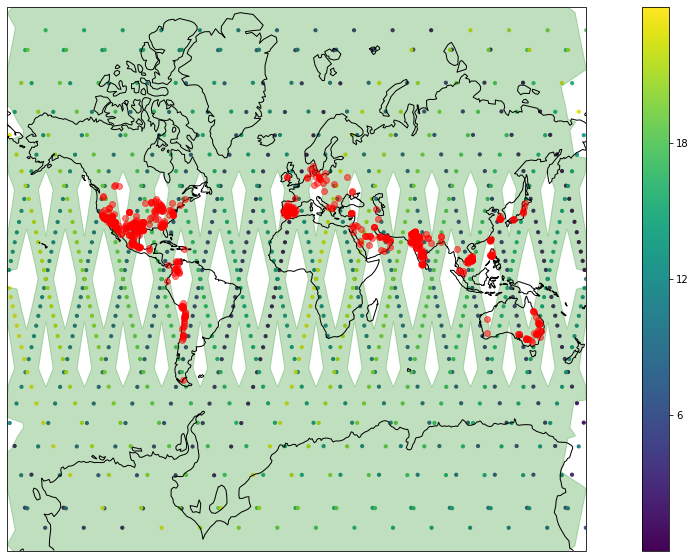

In [16]:
# And visualize it
farms_mercator = LatLon_to_Mercator(farm_data[:2])
ax.plot(farms_mercator[0, 50:], farms_mercator[1, 50:], 'o', alpha=0.5, color='red')
display(fig)

In [17]:
farm_data.shape

(3, 658)

Farm sizes as they are mean only 41% of the power beamed down by the satellites can be captured, averaging over the existing farms (on this one particular orbit).
The real number is smaller in reality, considering that the beam size is actually bigger when sun hits at an angle beacuse the distance to the satellite is larger (up to ~5x).
Plus cosine losses.


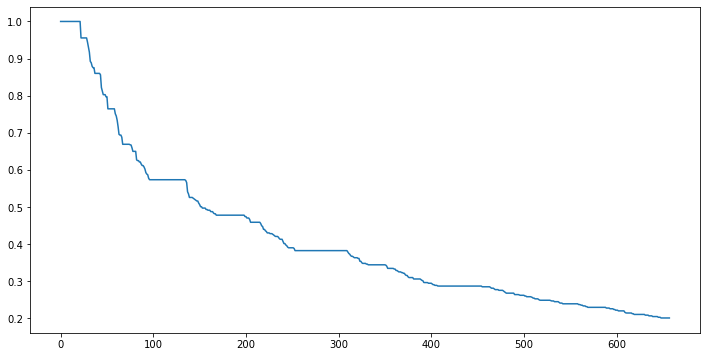

In [18]:
# Let's look at the minimum losses due to farm size being smaller than beam size (they are bigger if the rays hit at an angle)

min_losses = np.minimum(farm_area / min_beam_area, 1)
plt.figure(figsize=(12, 6))
plt.plot(-np.sort(-min_losses))
np.average(min_losses)

print(f"""Farm sizes as they are mean only {int(np.average(min_losses)*100)}% of the power beamed down by the satellites can be captured, averaging over the existing farms (on this one particular orbit).
The real number is smaller in reality, considering that the beam size is actually bigger when sun hits at an angle beacuse the distance to the satellite is larger (up to ~5x).
Plus cosine losses.""")

In [19]:
# We can start making sense of the transmission ratios from each orbit point to the different farms

sat_ecef = ECI_to_ECEF(sat_eci, t) # (3, orbit_points)
norm_sat_ecef = np.sqrt(dot(sat_ecef, sat_ecef)) # (orbit_points, )

farms_ecef = LatLon_to_ECEF(farm_data[:2]) # (3, farms)

farms_to_sat_ecef = sat_ecef[:, :, np.newaxis] - farms_ecef[:, np.newaxis, :] # (3, orbit_points, farms)
norm_farms_to_sat_ecef = np.sqrt(np.einsum('ijk, ijk->jk', farms_to_sat_ecef, farms_to_sat_ecef)) # (orbit_points, farms)
filter_fov = norm_farms_to_sat_ecef > np.sqrt((R+h)**2 - R**2)

scalar = np.einsum('ijk, ij->jk', farms_to_sat_ecef, sat_ecef) # (orbit_points, farms)
unit_scalar = scalar / (norm_sat_ecef[:, np.newaxis] * norm_farms_to_sat_ecef)
theta = np.pi/2 - np.arccos(unit_scalar) # Angle from the farm's surface to the satellite

sat_farm_transmission = 0.1283 + 0.7548*np.exp(-0.3866/np.sin(theta)) # Transmission loss due to longer atmospheric path

beam_area = np.pi * (norm_farms_to_sat_ecef * np.tan(sun_subtended) * 0.5)**2
area_losses = np.minimum(farm_area[np.newaxis, :] / beam_area, 1) if FARM_AREA_LOSSES else 1 # Losses due to beam being bigger than farm area
cos_losses = np.sin(theta) if FARM_COSINE_LOSSES else 1 # first order approx. We could be a bit more gentle and include it before taking the min before, but doesn't seem to do much difference 
sat_farm_transmission = sat_farm_transmission * area_losses * cos_losses
sat_farm_transmission[filter_fov] = 0 # disregard farms out of reach

The power transmitted to farms contemplating the actual distance from the satellite is 0.35x the amount blinldy taking the distance to be the altiutude.
That is, taking into account the actual area of the beam on the farm


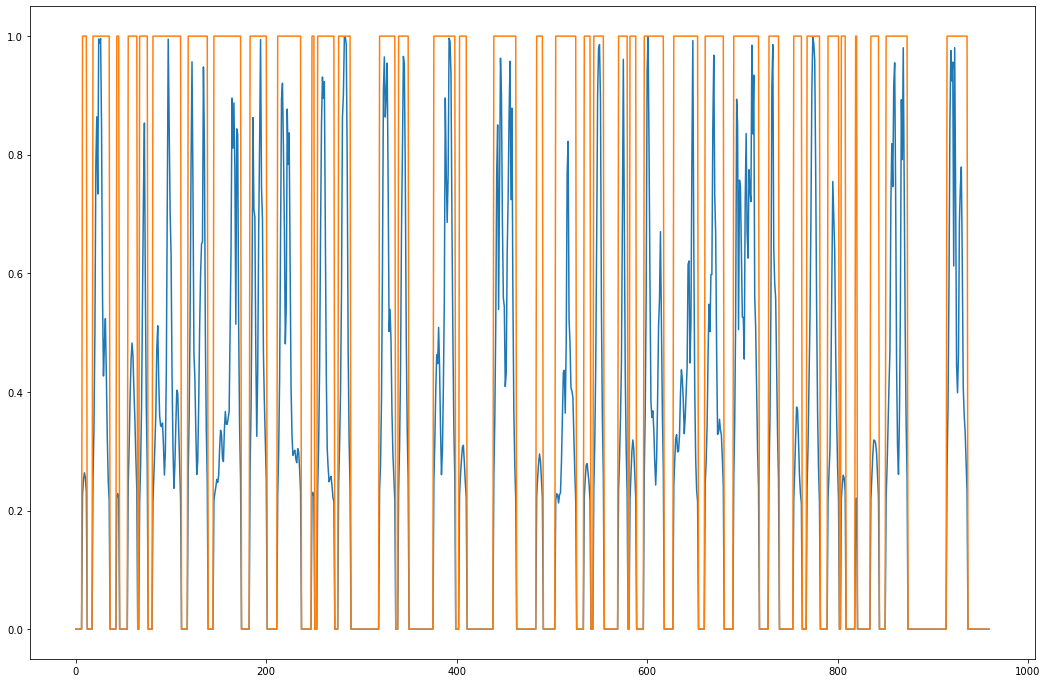

In [20]:
# Let's visualize the minimum distance to a farm on each point in along the orbit to get a sense of how close the above estimate for area loss was

quotient = h/norm_farms_to_sat_ecef # the quotient of the distances is the quotient of the area losses
quotient[filter_fov] = 0 # disregard farms out of sight

plt.figure(figsize=(18, 12))
plt.plot(np.max(quotient, axis=1)) # closest farm on each point along the orbit
plt.plot(np.max((~filter_fov).astype(int), axis=1)) # distance = orbit alitude if in sight else 0

print(f"""The power transmitted to farms contemplating the actual distance from the satellite is {np.round(quotient.sum()/(~filter_fov).sum(), 2)}x the amount blinldy taking the distance to be the altiutude.
That is, taking into account the actual area of the beam on the farm""")


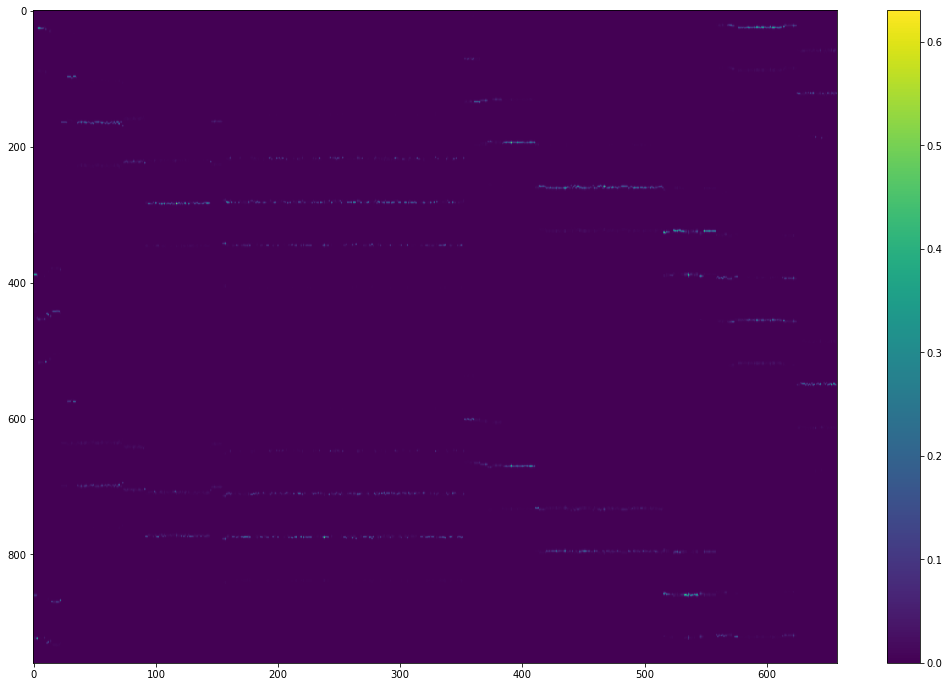

In [21]:
# Visualize satellite to farm transmission heatmap

plt.figure(figsize=(18, 12))
im = plt.imshow(sat_farm_transmission, aspect='auto')
plt.colorbar(im)

Average satellite to farm optimal transmission along orbit: 0.04151372860827237


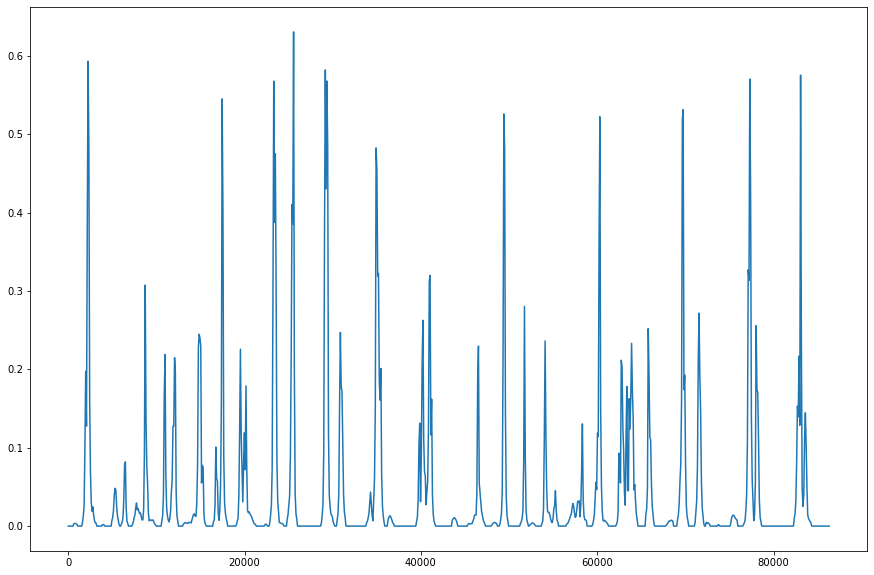

In [22]:
# Visualize optimal satellite to farm transmission along orbit

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(t, np.max(sat_farm_transmission, axis=1))
print(f"Average satellite to farm optimal transmission along orbit: {np.average(np.max(sat_farm_transmission, axis=1))}")

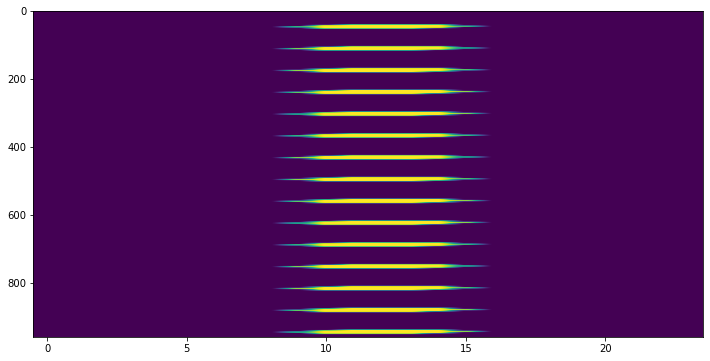

In [23]:
# But there's another source of loss: the satellite must be at an angle wrt the incoming rays to deviate them. 
# The higher the angle, the lower the exposed projected area and thus the lower the captured power

# Let's compute the direction of the incoming sun rays to calculate the angle needed for satellite X to point to farm Y

# One full year rotation
season = np.linspace(start=0, stop=2*np.pi, num=POINTS_PER_YEAR, endpoint=False) # (season_points,)

# Sun direction from the earth
sun_tilted = np.sin(season) # (season_points,) sun geocentric tilted x
sun_tilted = np.vstack((sun_tilted, -np.cos(season))) # (2, season_points) sun geocentric tilted y
sun_tilted = np.vstack((sun_tilted, np.zeros(season.shape))) # (3, season_points) sun geocentric tilted z
sun_eci = Tilted_to_ECI(sun_tilted) # (3, season_points)
sun_corotating = ECI_to_Corotating(sun_eci, season) # (3, season_points)

sat_corotating = sat_eci # (3, orbit_points)
farms_corotating = ECEF_to_Corotating(np.repeat(farms_ecef[:, np.newaxis, :], orbit_points, axis=1), t) # (3, orbit_points, farms) 

sat_to_farms_corotating = farms_corotating - sat_corotating[:, :, np.newaxis] # (3, orbit_points, farms)
norm_sat_to_farms_corotating = np.sqrt(np.einsum('ijk, ijk->jk', sat_to_farms_corotating, sat_to_farms_corotating)) # (orbit_points, farms)

farm_sun_cos2 = np.einsum('ijk, il->jkl', sat_to_farms_corotating, sun_corotating) # cos(2*theta) * ||sat_to_farm|| (orbit_points, farms, season_points)
farm_sun_cos2 = farm_sun_cos2 / norm_sat_to_farms_corotating[:, :, np.newaxis] # cos(2*theta) (orbit_points, farms, season_points)
sun_farm_transmission = np.sqrt(0.5*(farm_sun_cos2 + 1)) # cos(theta) (orbit_points, farms, season_points)

sat_sun_cos = np.einsum('ij, ik -> jk', sat_corotating, sun_corotating) # cosine of the angle between the sun and the satellite (orbit_points, season_points)
threshold = (R+h)**2 - R**2
filter_sun = (sat_sun_cos < 0) & (sat_sun_cos**2 > threshold) # the satellite is behind the earth wrt the sun
plt.figure(figsize=(12, 6))
plt.imshow(filter_sun, aspect='auto')
sun_farm_transmission[np.repeat(filter_sun[:, np.newaxis, :], farm_number, axis=1)] = 0

In [24]:
full_transmission = sat_farm_transmission[:, :, np.newaxis] * sun_farm_transmission  

In [25]:
# Let's go one more time with all the variables included

# This means incorporating 
# 1) a phase to the orbit (think of it as a displacement of the ground tracks so that the satellite goes over different longitudes at the equator)
# 2) a flavour: the angle of the orbit with respect to the sun. Both 0 and pi are dawn/dusk but they go over different sides of the poles

orbit_phase = np.linspace(start=0, stop=ORBIT_PERIOD, num=ORBIT_PHASES, endpoint=False) # (orbit_phases,)
tau = t[:, np.newaxis] - orbit_phase[np.newaxis, :] # (orbit_points, orbit_phases)

len_flavours = 2
flavour = np.linspace(start=0, stop=2*np.pi, num=len_flavours, endpoint=False) # (flavours,)

tau = tau[:, :, np.newaxis] # prepare for broadcast
flavour = flavour[np.newaxis, np.newaxis, :] # prepare for broadcast

sat_corotating_x = a*(np.cos(w_s*tau)*np.cos(flavour)-np.sin(w_s*tau)*np.sin(flavour)*np.cos(i)) # (orbit_points, orbit_phases, flavours) satellite cartesian x
sat_corotating_y = a*(np.cos(w_s*tau)*np.sin(flavour)+np.sin(w_s*tau)*np.cos(flavour)*np.cos(i)) # (orbit_points, orbit_phases, flavours) satellite cartesian y
sat_corotating_z = np.repeat((a*np.sin(w_s*tau)*np.sin(i)), len_flavours, axis=2) # (orbit_points, orbit_phases, flavours) satellite cartesian z
sat_corotating = np.stack((sat_corotating_x, sat_corotating_y, sat_corotating_z), axis=0) # (3, orbit_points, orbit_phases, flavours)

In [26]:
sat_to_farms_corotating = farms_corotating[:, :, np.newaxis, np.newaxis, :] - sat_corotating[:, :, :, :, np.newaxis] # (3, orbit_points, orbit_phases, flavours, farms)
norm_sat_to_farms_corotating = np.sqrt(np.einsum('ijklm, ijklm->jklm', sat_to_farms_corotating, sat_to_farms_corotating)) # (orbit_points, orbit_phases, flavours, farms)

# Sat to farm transmission
filter_fov = norm_sat_to_farms_corotating > np.sqrt((R+h)**2 - R**2) # which farms are out of sight for each point along the orbit?

scalar = np.einsum('ijklm, ijkl->jklm', -sat_to_farms_corotating, sat_corotating) # (orbit_points, orbit_phases, flavours, farms)
unit_scalar = scalar / (a * norm_sat_to_farms_corotating)
theta = np.pi/2 - np.arccos(unit_scalar) # Angle from the farm's surface to the satellite
sat_farm_transmission = 0.1283 + 0.7548*np.exp(-0.3866/np.sin(theta)) # Transmission loss due to longer atmospheric path

beam_area = np.pi * (norm_sat_to_farms_corotating * np.tan(sun_subtended) * 0.5)**2
area_losses = np.minimum(farm_area[np.newaxis, np.newaxis, np.newaxis, np.newaxis :] / beam_area, 1) if FARM_AREA_LOSSES else 1 # Losses due to beam being bigger than farm area
cos_losses = np.sin(theta) if FARM_COSINE_LOSSES else 1 # first order approx. We could be a bit more gentle and include it before taking the min before, but doesn't seem to do much difference 
sat_farm_transmission = sat_farm_transmission * area_losses * cos_losses
sat_farm_transmission[filter_fov] = 0 # disregard farms out of reach

# Sun to farm transmission
farm_sun_cos2 = np.einsum('ijklm, in->jklmn', sat_to_farms_corotating, sun_corotating) # cos(2*theta) * ||sat_to_farm|| (orbit_points, orbit_phases, flavours, farms, season_points)
farm_sun_cos2 = farm_sun_cos2 / norm_sat_to_farms_corotating[:, :, :, :, np.newaxis] # cos(2*theta) (orbit_points, farms, season_points)
sun_farm_transmission = np.sqrt(0.5*(farm_sun_cos2 + 1)) # cos(theta) (orbit_points, orbit_phases, flavours, farms, season_points)

sat_sun_cos = np.einsum('ijkl, in -> jkln', sat_corotating, sun_corotating) # cosine of the angle between the sun and the satellite (orbit_points, orbit_pases, flavours, season_points)
threshold = (R+h)**2 - R**2
filter_sun = (sat_sun_cos < 0) & (sat_sun_cos**2 > threshold) # the satellite is behind the earth wrt the sun
sun_farm_transmission[np.repeat(filter_sun[:, :, :, np.newaxis, :], farm_number, axis=3)] = 0

full_transmission  = sun_farm_transmission
full_transmission *= sat_farm_transmission[:, :, :, :, np.newaxis] # (orbit_points, orbit_pases, flavours, farms, season_points)


In [27]:
sellable_power  = full_transmission # how much power can be transfered to the solar farms (first for memory efficiency)
sellable_power *= SPACE_SOLAR_kWpm2 # how much power reaches LEO from the sun per m^2
sellable_power *= SAT_SURFACE # how much power can go through the satellite based on its area
sellable_power *= MYLAR_REFLECTIVITY # how much power the satelite can reflect based on its reflectivity
sellable_power *= SUNNY_SKY_FREQ # what percentage of the time will the climate conditions be optimal for transfer
sellable_power *= 1-PANEL_SPACING_LOSSES # what percentage of the light actually hits a solar panel
sellable_power *= PV_CELL_EFFICIENCY # how much power is harnessed by solar panels
sellable_power *= 1-SOLAR_INVERTER_LOSSES # how much power reaches the grid per satellite in kW

# sellable_power.shape is (orbit_points, orbit_phases, flavours, farms, anomaly_points)
  
optimal_sellable_power = np.max(sellable_power, axis=3) # consider optimal farm selection (orbit_points, orbit_phases, flavours, season_points)
annual_sellable_energy = np.trapz(optimal_sellable_power, dx=EARTH_ROTATION_PERIOD/POINTS_PER_ORBIT/60/60, axis=0) # how much energy can be sold in one day (orbit_phases, flavours, season_points)
annual_sellable_energy = np.trapz(annual_sellable_energy, dx=365/POINTS_PER_YEAR, axis=2) # (orbit_phases, flavours)

annual_revenue = annual_sellable_energy * ENERGY_PRICE

total_sat_cost = SAT_COST + SAT_WEIGHT * KG_COST_TO_ORBIT

lifetime_energy_output = annual_sellable_energy * SAT_LIFE
LCOE = total_sat_cost / lifetime_energy_output

annual_returns = annual_revenue / total_sat_cost

In [28]:
optimal_sellable_power[0, :, : , 0]

array([[ 0.        , 28.95104996],
       [ 0.        ,  0.        ],
       [27.9634757 ,  0.        ],
       [ 0.        ,  0.        ]])

In [29]:
# Find the best orbit and its stats

phase_, flavour_ = np.unravel_index(np.argmax(annual_sellable_energy), annual_sellable_energy.shape) 

print(f"For the optimal orbit found:")
print("\n")
print(f"LCOE:                 ${np.round(LCOE[phase_, flavour_], decimals=3)}/kWh")
print(f"Annual revenue:       ${int(annual_revenue[phase_, flavour_])}")
print(f"Annual ROI:           {np.round(annual_returns[phase_, flavour_]*100, 2)}%")
print(f"Annual energy output: {int(annual_sellable_energy[phase_, flavour_])}kWh")
print(f"Satelite cost:        ${int(total_sat_cost)}")
print(f"  Manufacturing:      ${int(SAT_COST)} ({int(np.round(SAT_COST/total_sat_cost*100))}%)")
print(f"  Launch:             ${SAT_WEIGHT * KG_COST_TO_ORBIT} ({int(np.round(SAT_WEIGHT * KG_COST_TO_ORBIT/total_sat_cost*100))}%)")
print("\n")
print(f"Satellites needed in orbit to reach $100M in annual revenue: {int(100000000/annual_revenue[phase_, flavour_])}")


For the optimal orbit found:


LCOE:                 $0.11/kWh
Annual revenue:       $10529
Annual ROI:           3.76%
Annual energy output: 126866kWh
Satelite cost:        $280000
  Manufacturing:      $40000 (14%)
  Launch:             $240000 (86%)


Satellites needed in orbit to reach $100M in annual revenue: 9496


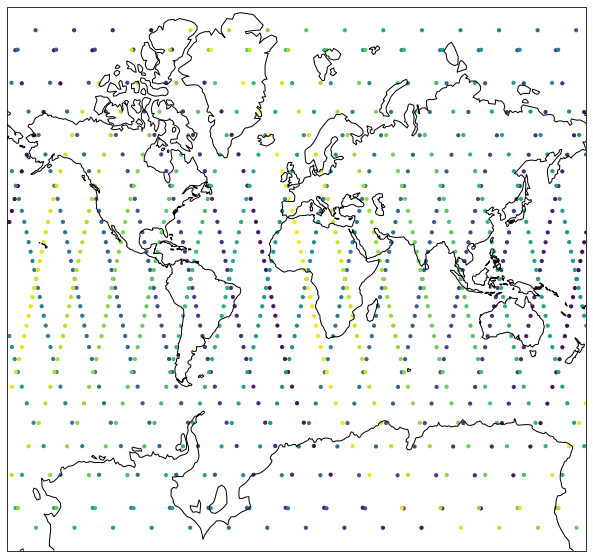

In [30]:
# Plot it

optimal_orbit_tracks = ECI_to_LatLon(sat_corotating[:, :, phase_, flavour_], t)
optimal_orbit_tracks = LatLon_to_Mercator(optimal_orbit_tracks)

max_lat = 84

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.Mercator(min_latitude=-max_lat, max_latitude=max_lat)})

sat_ground_track = ax.scatter(optimal_orbit_tracks[0], optimal_orbit_tracks[1], c=t/60/60, s=10)
ax.coastlines()

x_lim = R*np.pi
y_lim = R*np.log(np.tan(np.deg2rad(max_lat/2)+np.pi/4))
ax.set_xlim([-x_lim, x_lim])
ax.set_ylim([-y_lim, y_lim])
plt.show()